In [1]:
import os
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, Reshape, concatenate
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras.models import Model
from keras.layers.core import RepeatVector
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import datetime

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
load_ext tensorboard

In [4]:
#Get all the images in 'Train' Folder in a single array
X = []                                                  #empty array
for filename in os.listdir('Train/'):
    X.append(img_to_array(load_img('Train/'+filename))) #appending all images converted to RGB intensity values (3,0-255) in X
X = np.array(X, dtype=float)
Xtrain = 1.0/255*X                                      #Normalizing for tanh activation function

In [5]:
np.shape(Xtrain) #Dimensions of Xtrain

(14, 256, 256, 3)

In [3]:
#Instantiating an InceptionResNetV2 architecture, taking weights from Imagenet CNN Model
inception = InceptionResNetV2(weights='imagenet', include_top=True) #includes fully connected layer on top

In [4]:
inception.load_weights('inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5') #Loading predefined weights

In [7]:
embed_input = Input(shape=(1000,))
np.shape(embed_input)

TensorShape([None, 1000])

# Upsampling & Downsampling Operation
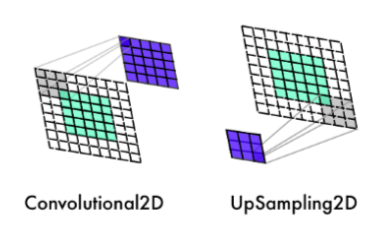

In [9]:
#Encoder / AutoEncoder
encoder_input = Input(shape=(256, 256, 1,)) #Input Shape is a 256x256 Image
encoder_output = Conv2D(64, (3,3),  activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)# Upsampling & Downsampling Operation

# The Fusion Layer 
    W x H of Input Image = 256 x 256
    
In the fusion layer, we first multiply the 1000 Category layers by 1024 (i.e 32 * 32). 
This is then reshaped from 2D to 3D, a 32 x 32 grid with the 1000 pillars. 
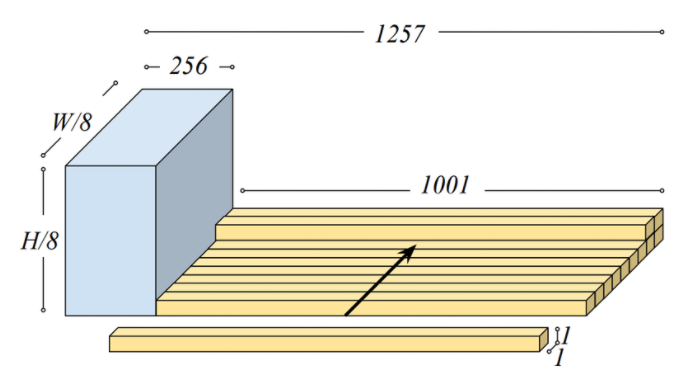

In [10]:
#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input)  #creates the Fusion Layer by repeating the input from classfier 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) #along the left facing axis
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)

In [11]:
#Decoder / Autodecoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

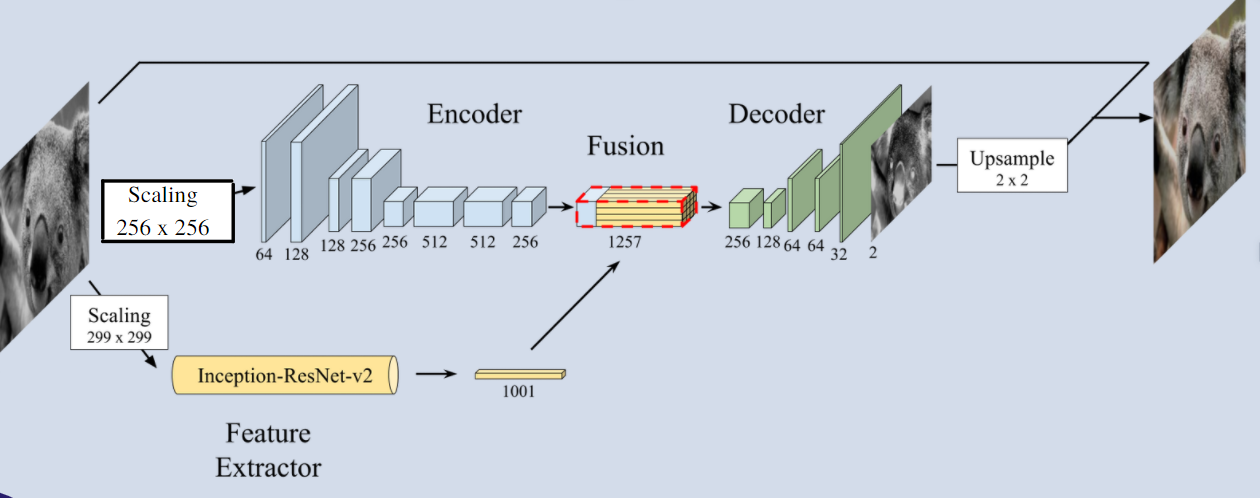

    The encoder_input is fed into our Encoder model
    Output of the Encoder model is then fused with the embed_input in the fusion layer
    Output of the fusion is then used as input in the Decoder model, which then returns the final output, decoder_output

In [13]:
colorization_model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output) #Joining the above 3 Networks

In [8]:
#Create embedding
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []                                 #to store required size image,i.e. 299x299
    for i in grayscaled_rgb:                                    #resizing all training images to pass through InceptionResNetV2
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)                        #appending all images with only L values (0-255) in X
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized) #The 'preprocess_input' is meant to adjust image to model 
                                                                      #required format
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.4,
        zoom_range=0.4,
        rotation_range=40,
        horizontal_flip=True)

#Generate training data
batch_size = 1000000
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size): 
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)

    adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to    update network weights iterative based in training data.
   
    Optimizers are algorithms or methods used to change the attributes of neural networks such as weights and learning rate in order to reduce the losses.
    
    Mean squared error (MSE) is a common loss function for regressions.
    
    Loss functions are a measure of how good a prediction model does in terms of being able to predict the expected outcome

__As the number of epochs increases, more number of times the weight are changed in the neural network and the curve goes from underfitting to optimal to overfitting curve.__

In [14]:
#compile and evaluate loaded model
colorization_model.compile(optimizer='adam', loss='mse') 

In [17]:
#%reload_ext tensorboard
logdir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [16]:
colorization_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 128, 128, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 128, 128, 128 73856       conv2d_203[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 64, 64, 128)  147584      conv2d_204[0][0]                 
______________________________________________________________________________________________

In [23]:
with tf.device('/GPU:0'):
    colorization_model.fit(image_a_b_gen(batch_size), epochs=26, steps_per_epoch=100, callbacks=[tensorboard_callback])

Epoch 1/26
100/100 [==============================] - 135s 1s/step - loss: 3.7954e-04
Epoch 2/26
100/100 [==============================] - 134s 1s/step - loss: 3.7780e-04
Epoch 3/26
100/100 [==============================] - 132s 1s/step - loss: 3.6188e-04
Epoch 4/26
100/100 [==============================] - 133s 1s/step - loss: 3.7686e-04
Epoch 5/26
100/100 [==============================] - 133s 1s/step - loss: 0.0046
Epoch 6/26
100/100 [==============================] - 133s 1s/step - loss: 0.0024
Epoch 7/26
100/100 [==============================] - 133s 1s/step - loss: 0.0011
Epoch 8/26
100/100 [==============================] - 134s 1s/step - loss: 7.6111e-04
Epoch 9/26
100/100 [==============================] - 134s 1s/step - loss: 5.8592e-04
Epoch 10/26
100/100 [==============================] - 134s 1s/step - loss: 5.1078e-04
Epoch 11/26
100/100 [==============================] - 135s 1s/step - loss: 5.0143e-04
Epoch 12/26
100/100 [==============================] - 137s 1s/s

In [23]:
%tensorboard --logdir logs/ --host localhost --port 6009

Reusing TensorBoard on port 6009 (pid 16736), started 15:25:35 ago. (Use '!kill 16736' to kill it.)

In [19]:
#Saving the trained Model
colorization_model.save('colorization_model.h5')

In [20]:
#Make a prediction on the unseen images in Test Folder
color_me = []
for filename in os.listdir('Test/'):
    color_me.append(img_to_array(load_img('Test/'+filename)))
color_me = np.array(color_me, dtype=float)
color_me = 1.0/255*color_me
gray_me = gray2rgb(rgb2gray(color_me))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

In [21]:
# Test model
output = colorization_model.predict([color_me, color_me_embed])
output = output * 128 #As the values were normalized between -1 and 1, instead of -128,128 range of a,b in Lab Colorspace

In [ ]:
# Final Output colorizations
for i in range(len(output)):
    res = np.zeros((256, 256, 3)) #Black Canvas
    res[:,:,0] = color_me[i][:,:,0]
    res[:,:,1:] = output[i]
    imsave("Results/img_"+str(i)+".png", lab2rgb(res)) #converting Lab image back to RGB for easier Visualization

The training loss is the average of the losses over each batch of training data. On the other hand, the testing loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss.

# Load Pre-trained Model and Predict

In [9]:
#Make a prediction on the unseen images in Test Folder
color_me = []
for filename in os.listdir('Test/'):
    color_me.append(img_to_array(load_img('Test/'+filename)))
color_me = np.array(color_me, dtype=float)
color_me = 1.0/255*color_me
gray_me = gray2rgb(rgb2gray(color_me))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

#To load a model
loaded_model = tf.keras.models.load_model('colorization_model.h5')

Output_new = loaded_model.predict([color_me, color_me_embed])*128

# Final Output colorizations
for i in range(len(Output_new)):
    res = np.zeros((256, 256, 3)) #Black Canvas
    res[:,:,0] = color_me[i][:,:,0]
    res[:,:,1:] = Output_new[i]
    imsave("Results/img_"+str(i)+".png", lab2rgb(res)) #converting Lab image back to RGB for easier Visualization

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
c:\users\snikh\appdata\local\programs\python\python38\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
